Step 1: Preprocess the Text Data (Title Column)

Tokenization: Split each article title into individual words.
Vocabulary Creation: Create a vocabulary from all unique words in the titles and assign each word a unique ID.
Padding: Ensure each title has the same length by padding shorter titles or truncating longer ones.

In [1]:
import pandas as pd
import sentencepiece as spm
from sklearn.model_selection import train_test_split
import numpy as np
import torch

Preparing the GloVe embeddings and tokenizer 

In [4]:
import zipfile
from huggingface_hub import hf_hub_download
from pathlib import Path
from tqdm import tqdm
from typing import Tuple, List
import torch
import tokenizers
import rich

# Load GloVe embeddings
def load_glove_vectors(filename="glove.6B.300d.txt") -> Tuple[List[str], torch.Tensor]:
    """
    Load the GloVe vectors and parse vocabulary and vectors.

    Args:
        filename (str): Name of the GloVe file to load.

    Returns:
        vocabulary (List[str]): List of words in the GloVe vocabulary.
        vectors (torch.Tensor): Tensor of embedding vectors.
    """
    # Download GloVe file from Hugging Face hub
    path = Path(hf_hub_download(repo_id="stanfordnlp/glove", filename="glove.6B.zip"))
    target_file = path.parent / filename

    # Extract GloVe file if not already extracted
    if not target_file.exists():
        with zipfile.ZipFile(path, "r") as zip_ref:
            zip_ref.extractall(path.parent)

        # Ensure target file exists after extraction
        if not target_file.exists():
            print("Available files:")
            for p in path.parent.iterdir():
                print(p)
            raise ValueError(
                f"Target file `{target_file.name}` can't be found. Check if `{filename}` was properly downloaded."
            )

    # Parse vocabulary and vectors
    vocabulary = []
    vectors = []
    with open(target_file, "r", encoding="utf8") as f:
        for line in tqdm(f.readlines(), desc=f"Parsing {target_file.name}..."):
            word, *vector = line.split()
            vocabulary.append(word)
            vectors.append(torch.tensor([float(v) for v in vector], dtype=torch.float32))
    vectors = torch.stack(vectors)
    return vocabulary, vectors



In [ ]:
# Prepare data
glove_vocabulary, glove_vectors = load_glove_vectors() #glove voc is a list of words from the glove embeddings , glove vec is a tensor where each row represents the embedding of a word in glove voc 
rich.print(f"glove_vocabulary: type={type(glove_vocabulary)}, length={len(glove_vocabulary)}")
rich.print(f"glove_vectors: type={type(glove_vectors)}, shape={glove_vectors.shape}, dtype={glove_vectors.dtype}")

# Add special tokens
special_tokens = ['<|start|>', '<|unknown|>', '<|pad|>']  # add special toeksn , useful for seq processing
glove_vocabulary = special_tokens + glove_vocabulary # creates random embeddings for these tokens with the same dim as other glove embeddings
glove_vectors = torch.cat([torch.randn(len(special_tokens), glove_vectors.shape[1]), glove_vectors]) # concatenates these new embeddings to the glove vectors

# Tokenizer for GloVe
glove_tokenizer = tokenizers.Tokenizer( # A WordLevel tokenizer maps each word in the vocabulary to a unique integer (token ID).
    tokenizers.models.WordLevel(vocab={v: i for i, v in enumerate(glove_vocabulary)}, unk_token="<|unknown|>") # The tokenizer uses <|unknown|> as a fallback for words not found in the vocabulary.
)
glove_tokenizer.normalizer = tokenizers.normalizers.BertNormalizer(strip_accents=False)
glove_tokenizer.pre_tokenizer = tokenizers.pre_tokenizers.Whitespace()

Parsing glove.6B.300d.txt...: 100%|██████████| 400001/400001 [00:42<00:00, 9495.53it/s]


glove_vocabulary: type=<class 'list'>, length=400001

glove_vectors: type=<class 'torch.Tensor'>, shape=torch.Size([400001, 300]), dtype=torch.float32

In [10]:
import pandas as pd
import torch
from sklearn.model_selection import train_test_split

# Step 1: Load train and validation datasets
dataset_train_parquet = "/dtu/blackhole/1e/203774/output for training data /small output read file/final_df_new.parquet"
df_train = pd.read_parquet(dataset_train_parquet, engine="pyarrow")

dataset_validation_parquet = "/dtu/blackhole/1e/203774/output for validation data /small output read final/final_df_new.parquet"
df_validation = pd.read_parquet(dataset_validation_parquet, engine="pyarrow")

# Combine train and validation titles into a single process for tokenization and padding
all_titles = pd.concat(
    [df_train["title"].fillna(""), df_validation["title"].fillna("")], ignore_index=True
).tolist()

# News Encoder

In [23]:
import torch
import torch.nn as nn
import torch.nn.functional as F

# Word Embedding Layer
class WordEmbeddings(nn.Module):
    def __init__(self, embedding_matrix):
        super(WordEmbeddings, self).__init__()
        self.embedding = nn.Embedding.from_pretrained(
            embeddings=torch.tensor(embedding_matrix, dtype=torch.float32),
            freeze=True  # Set to False to fine-tune embeddings
        )

    def forward(self, inputs):
        embeddings = self.embedding(inputs)
        return embeddings


# Multi-Head Self-Attention Layer (Vectorized)
class MultiHeadSelfAttention(nn.Module):
    def __init__(self, embed_dim, num_heads):
        super(MultiHeadSelfAttention, self).__init__()
        assert embed_dim % num_heads == 0, "embed_dim must be divisible by num_heads"

        self.num_heads = num_heads
        self.head_dim = embed_dim // num_heads

        # Linear projections for Q, K, and V
        self.query_projection = nn.Linear(embed_dim, embed_dim)
        self.key_projection = nn.Linear(embed_dim, embed_dim)
        self.value_projection = nn.Linear(embed_dim, embed_dim)

        # Output projection
        self.out_projection = nn.Linear(embed_dim, embed_dim)

    def forward(self, inputs):
        """
        Args:
            inputs (torch.Tensor): Input tensor of shape (batch_size, seq_len, embed_dim)

        Returns:
            output (torch.Tensor): Output tensor of shape (batch_size, seq_len, embed_dim)
            attention_weights (torch.Tensor): Attention weights of shape (batch_size, num_heads, seq_len, seq_len)
        """
        batch_size, seq_len, embed_dim = inputs.size()

        # Project inputs to queries, keys, and values
        Q = self.query_projection(inputs)  # (batch_size, seq_len, embed_dim)
        K = self.key_projection(inputs)  # (batch_size, seq_len, embed_dim)
        V = self.value_projection(inputs)  # (batch_size, seq_len, embed_dim)

        # Reshape to separate heads
        Q = Q.view(batch_size, seq_len, self.num_heads, self.head_dim).transpose(1, 2)  # (batch_size, num_heads, seq_len, head_dim)
        K = K.view(batch_size, seq_len, self.num_heads, self.head_dim).transpose(1, 2)  # (batch_size, num_heads, seq_len, head_dim)
        V = V.view(batch_size, seq_len, self.num_heads, self.head_dim).transpose(1, 2)  # (batch_size, num_heads, seq_len, head_dim)

        # Compute scaled dot-product attention
        attention_scores = torch.matmul(Q, K.transpose(-2, -1)) / torch.sqrt(torch.tensor(self.head_dim, dtype=torch.float32))  # (batch_size, num_heads, seq_len, seq_len)
        attention_weights = F.softmax(attention_scores, dim=-1)  # Normalize over seq_len

        # Compute context
        context = torch.matmul(attention_weights, V)  # (batch_size, num_heads, seq_len, head_dim)

        # Concatenate heads and project the output
        context = context.transpose(1, 2).contiguous().view(batch_size, seq_len, embed_dim)  # (batch_size, seq_len, embed_dim)
        output = self.out_projection(context)  # (batch_size, seq_len, embed_dim)

        return output, attention_weights


# Additive Word Attention Layer
class AdditiveWordAttention(nn.Module):
    def __init__(self, embed_dim, query_dim):
        super(AdditiveWordAttention, self).__init__()
        self.Vw = nn.Linear(embed_dim, query_dim, bias=True)
        self.qw = nn.Parameter(torch.randn(query_dim))

    def forward(self, inputs):
        """
        Args:
            inputs (torch.Tensor): Tensor of shape (batch_size, seq_len, embed_dim)

        Returns:
            weighted_sum (torch.Tensor): Tensor of shape (batch_size, embed_dim)
            attention_weights (torch.Tensor): Tensor of shape (batch_size, seq_len)
        """
        projection = self.Vw(inputs)  # (batch_size, seq_len, query_dim)
        scores = torch.tanh(projection)  # Non-linear transformation
        attention_scores = torch.matmul(scores, self.qw)  # (batch_size, seq_len)
        attention_weights = F.softmax(attention_scores, dim=1)  # Normalize over seq_len
        weighted_sum = torch.sum(inputs * attention_weights.unsqueeze(-1), dim=1)  # Weighted sum of embeddings

        return weighted_sum, attention_weights


# News Encoder
class NewsEncoder(nn.Module):
    def __init__(self, embedding_matrix, embed_dim, num_heads, query_dim, dropout=0.2):
        super(NewsEncoder, self).__init__()
        self.word_embeddings = nn.Embedding.from_pretrained(
            embedding_matrix.clone().detach(), freeze=False
        )
        self.self_attention = MultiHeadSelfAttention(embed_dim=embed_dim, num_heads=num_heads)
        self.additive_attention = AdditiveWordAttention(embed_dim=embed_dim, query_dim=query_dim)
        self.dropout = nn.Dropout(dropout)

    def forward(self, inputs):
        """
        Args:
            inputs (torch.Tensor): Input tensor of shape (batch_size, seq_len)

        Returns:
            news_representation (torch.Tensor): Tensor of shape (batch_size, embed_dim)
            attention_weights (torch.Tensor): Tensor of shape (batch_size, seq_len)
        """
        x = self.word_embeddings(inputs)  # Shape: (batch_size, seq_len, embed_dim)
        x = self.dropout(x)

        # Multi-Head Self-Attention
        attn_output, _ = self.self_attention(x)

        # Additive Attention
        news_representation, attention_weights = self.additive_attention(attn_output)

        return news_representation, attention_weights


### Purpose of Tokenization
Tokenization converts text (titles in this case) into numerical representations (sequences of token IDs). This is a required preprocessing step before feeding the data into a machine learning model.

- Train data: Tokenized versions of the titles will be used to train the model.
- Validation data: Tokenized titles are used to evaluate the model during training to monitor its performance on unseen data.


In [11]:
# Step 2: Tokenize titles
encoded_titles = [glove_tokenizer.encode(title).ids for title in all_titles]

Tokenization prepares train and validation data into a format the model can process (sequences of token IDs). We need both datasets tokenized because the model must be trained on one (train) and evaluated on another (validation) to ensure it can generalize well.

In [13]:
# Step 3: Dynamically determine max length
max_length = max(len(encoded) for encoded in encoded_titles)
print(f"Dynamically determined max length: {max_length}")

# Step 4: Pad or truncate the tokenized titles
padded_titles = torch.zeros((len(encoded_titles), max_length), dtype=torch.long)
for i, encoded in enumerate(encoded_titles):
    length = min(len(encoded), max_length)
    padded_titles[i, :length] = torch.tensor(encoded[:length])

# Step 5: Separate padded titles back into train and validation
num_train = len(df_train)
train_data = padded_titles[:num_train]
val_data = padded_titles[num_train:]

# Detach to prevent gradient tracking
train_data = train_data.clone().detach()
val_data = val_data.clone().detach()

print("Data preparation for both train and validation sets is complete.")

# Step 6: Evaluation to Verify
print(f"Train data shape: {train_data.shape}")
print(f"Validation data shape: {val_data.shape}")

# Example: Check padding correctness
print("First padded train title:", train_data[0])
print("First padded validation title:", val_data[0])


Dynamically determined max length: 12
Data preparation for both train and validation sets is complete.
Train data shape: torch.Size([1000, 12])
Validation data shape: torch.Size([1000, 12])
First padded train title: tensor([  687,  8452, 12233,     1,   649, 37972,   730,  1304,     0,     0,
            0,     0])
First padded validation title: tensor([     1,     48,  14770, 218796,      1,      0,      0,      0,      0,
             0,      0,      0])


- max length 12 : The length of the longest tokenized title in our combined traind and validaiton datasets is 12 tokens (this max length determines how many tokens each title will have after padding or truncation, titles shorter than 12 tokens are padded with zeros, and titles longer than 12 tokens are truncated to fit this length).
- Train Data Shape ([1000, 12]): There are 1000 titles in our training dataset, 12: Each title has been padded or truncated to a fixed length of 12 tokens.
- Validation Data Shape ([1000, 12]): there are 1000 titles in your validation dataset, 12: Each title has also been padded or truncated to the same length of 12 tokens.

1. Forward Pass with Prepared Data

In [24]:
# Initialize NewsEncoder
news_encoder = NewsEncoder(
    embedding_matrix=glove_vectors.clone().detach(),
    embed_dim=glove_vectors.shape[1],  # 300 (GloVe embedding dimension)
    num_heads=6,  # Number of attention heads
    query_dim=128,  # Additive attention query dimension
    dropout=0.2
)

# Move to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
news_encoder.to(device)
train_data = train_data.to(device)
val_data = val_data.to(device)

# Forward pass
news_encoder.eval()  # Disable dropout for evaluation
train_representations, train_attention_weights = news_encoder(train_data)
val_representations, val_attention_weights = news_encoder(val_data)

# Check output shapes
print(f"Train Representations Shape: {train_representations.shape}")  # Expected: (num_train_samples, 300)
print(f"Validation Representations Shape: {val_representations.shape}")  # Expected: (num_val_samples, 300)
print(f"Train Attention Weights Shape: {train_attention_weights.shape}")  # Expected: (num_train_samples, seq_len)
print(f"Validation Attention Weights Shape: {val_attention_weights.shape}")  # Expected: (num_val_samples, seq_len)


Train Representations Shape: torch.Size([1000, 300])
Validation Representations Shape: torch.Size([1000, 300])
Train Attention Weights Shape: torch.Size([1000, 12])
Validation Attention Weights Shape: torch.Size([1000, 12])


2. Validate Attention Weights

In [25]:
# Sum of attention weights should be 1 for each sequence
train_attn_sum = train_attention_weights.sum(dim=1)
val_attn_sum = val_attention_weights.sum(dim=1)

print("Train Attention Weights Sum:", train_attn_sum[:5])  # Should be close to 1
print("Validation Attention Weights Sum:", val_attn_sum[:5])  # Should be close to 1


Train Attention Weights Sum: tensor([1., 1., 1., 1., 1.], grad_fn=<SliceBackward0>)
Validation Attention Weights Sum: tensor([1.0000, 1.0000, 1.0000, 1.0000, 1.0000], grad_fn=<SliceBackward0>)


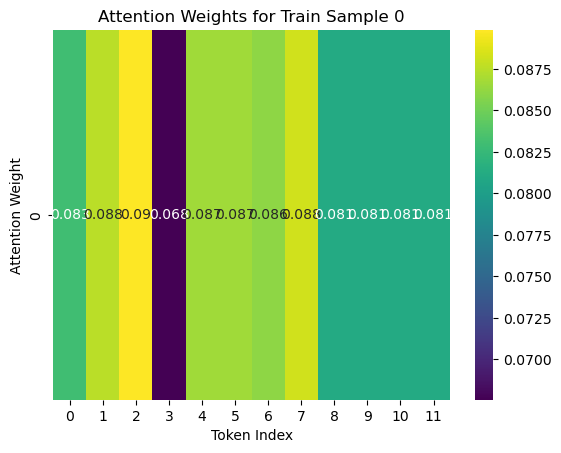

In [27]:
import matplotlib.pyplot as plt
import seaborn as sns

# Visualize attention weights for the first train sample
sample_idx = 0  # Choose a sample index
attention_weights_sample = train_attention_weights[sample_idx].detach().cpu().numpy()

sns.heatmap(attention_weights_sample.reshape(1, -1), cmap="viridis", annot=True)
plt.title(f"Attention Weights for Train Sample {sample_idx}")
plt.xlabel("Token Index")
plt.ylabel("Attention Weight")
plt.show()


## More tests 

In [ ]:
import torch

# Extract the first 5 rows of the train_titles tensor
sample_titles = train_data[:1000]  # Slice the first 5 rows

# Pass the sample titles through the News Encoder
news_representations, attention_weights = news_encoder(sample_titles)

# Display the output shapes
print("Sample Titles Shape:", sample_titles.shape)  
print("News Representations Shape:", news_representations.shape)
print("Attention Weights Shape:", attention_weights.shape)  


Sample Titles Shape: torch.Size([1000, 12])
News Representations Shape: torch.Size([1000, 300])
Attention Weights Shape: torch.Size([1000, 12])


In [35]:
import pandas as pd

# Convert attention weights to a DataFrame for readability
attention_df = pd.DataFrame(attention_weights.detach().numpy())

# Add column headers to identify word positions
attention_df.columns = [f"Word {i+1}" for i in range(max_length)]

# Display the DataFrame
print("Attention Weights (as Table):")
print(attention_df)


Attention Weights (as Table):
       Word 1    Word 2    Word 3    Word 4    Word 5    Word 6    Word 7  \
0    0.083001  0.087509  0.089835  0.067568  0.086682  0.086646  0.086043   
1    0.083001  0.087509  0.089835  0.067568  0.086682  0.086646  0.086043   
2    0.083001  0.087509  0.089835  0.067568  0.086682  0.086646  0.086043   
3    0.083001  0.087509  0.089835  0.067568  0.086682  0.086646  0.086043   
4    0.083001  0.087509  0.089835  0.067568  0.086682  0.086646  0.086043   
..        ...       ...       ...       ...       ...       ...       ...   
995  0.062711  0.089692  0.062711  0.081305  0.074806  0.062711  0.091231   
996  0.062711  0.089692  0.062711  0.081305  0.074806  0.062711  0.091231   
997  0.062711  0.089692  0.062711  0.081305  0.074806  0.062711  0.091231   
998  0.062711  0.089692  0.062711  0.081305  0.074806  0.062711  0.091231   
999  0.062711  0.089692  0.062711  0.081305  0.074806  0.062711  0.091231   

       Word 8    Word 9   Word 10   Word 11  

Check Validity

In [36]:
import torch


# Sum the attention weights across the sequence dimension (axis=1)
attention_sum = torch.sum(attention_weights, dim=1)  # Shape: (batch_size, 1)

# Print the result to verify it sums to ~1 for each sequence in the batch
print("Attention Weights Sum (per sequence):\n", attention_sum.detach().numpy())


Attention Weights Sum (per sequence):
 [1.        1.        1.        1.        1.        1.        1.
 1.        1.        1.        1.        1.        1.        1.
 1.        1.        1.        1.        1.        1.        1.
 1.        1.        1.        1.        1.        1.        1.
 1.        1.        1.        1.        1.        1.        1.
 1.        1.        1.        1.        1.        1.        1.
 1.        1.        1.        1.        1.        1.        1.
 1.        1.        1.        1.        1.        1.        1.
 1.        1.        1.        1.        1.        1.        1.
 1.        1.        1.        1.        1.        1.        1.
 1.        1.        1.        1.        1.        1.        1.
 1.        1.        1.        1.        1.        1.        1.
 1.        1.        1.        1.        1.        1.        1.
 1.        1.        1.        1.        1.        1.        1.
 1.        1.        1.        1.        1.        1.        1.
 

In [37]:
import torch
from torch.nn.functional import cosine_similarity

# Select two representations to compare
vector1 = news_representations[3]
vector2 = news_representations[4]

# Compute cosine similarity using PyTorch
similarity = cosine_similarity(vector1.unsqueeze(0), vector2.unsqueeze(0)).item()
print("Cosine similarity between Title 1 and Title 2 representations:", similarity)


Cosine similarity between Title 1 and Title 2 representations: 1.0000001192092896


In [38]:
import torch

# Assume we have 10 users and 20 news articles
num_users = 10
num_news = 20

# Randomly assign labels (1 = clicked, 0 = not clicked)
labels = torch.randint(0, 2, (num_users, num_news))

# Generate random user embeddings (e.g., 300-dimensional)
user_representations = torch.randn(num_users, 300)

# Use the news representations from the encoder
news_representations = train_representations[:num_news]  # Use first 20 news items

# Compute click probabilities using dot product
click_scores = torch.matmul(user_representations, news_representations.T)


In [39]:
from sklearn.metrics import roc_auc_score

# Flatten scores and labels for AUC computation
click_scores_flat = click_scores.flatten().detach().numpy()
labels_flat = labels.flatten().numpy()

# Compute AUC
auc = roc_auc_score(labels_flat, click_scores_flat)
print("AUC:", auc)


AUC: 0.6012787723785167


In [40]:
import numpy as np

def dcg_at_k(scores, labels, k):
    """Compute Discounted Cumulative Gain (DCG) at K."""
    sorted_indices = np.argsort(scores)[::-1]  # Sort by descending scores
    sorted_labels = labels[sorted_indices]
    return np.sum((2 ** sorted_labels[:k] - 1) / np.log2(np.arange(2, k + 2)))

def ndcg_at_k(scores, labels, k):
    """Compute Normalized DCG at K."""
    ideal_dcg = dcg_at_k(labels, labels, k)  # Perfect ordering
    if ideal_dcg == 0:
        return 0
    return dcg_at_k(scores, labels, k) / ideal_dcg

# Compute nDCG@k for each user
k = 5  # Top-k items
ndcg_scores = []
for user_idx in range(num_users):
    ndcg = ndcg_at_k(
        scores=click_scores[user_idx].detach().numpy(),
        labels=labels[user_idx].numpy(),
        k=k,
    )
    ndcg_scores.append(ndcg)

# Average nDCG@k across users
avg_ndcg = np.mean(ndcg_scores)
print(f"Average nDCG@{k}:", avg_ndcg)


Average nDCG@5: 0.3944757383133549


In [41]:
def mrr(scores, labels):
    """Compute Mean Reciprocal Rank (MRR)."""
    reciprocal_ranks = []
    for user_idx in range(len(labels)):
        sorted_indices = np.argsort(scores[user_idx])[::-1]
        sorted_labels = labels[user_idx][sorted_indices]
        rank = np.where(sorted_labels == 1)[0]
        if len(rank) > 0:
            reciprocal_ranks.append(1 / (rank[0] + 1))  # Rank is 0-based
    return np.mean(reciprocal_ranks)

# Compute MRR
mrr_score = mrr(click_scores.detach().numpy(), labels.numpy())
print("MRR:", mrr_score)


MRR: 0.5833333333333333
